In [1]:
# use kernel/conda env called "oliviaJupyter" 
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime
import imageio
from scipy.ndimage import gaussian_filter, uniform_filter
%matplotlib  widget

In [3]:
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/'
cropdir = 'cropped_9000_1800_18000_3600/'
dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
nd=len(dates) #nd is 211 as of 5-19-22

# for the entire region 
x1=0; y1=0
#dx=10000
dx=18000
#dy=1780
dy=3600

# for smaller region with interesting TPC feature
x1=8000; x2=11000; y1=1100; y2=1800
dx=x2-x1
dy=y2-y1

# load precip data
precip = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip_2days.txt') # still in inches
# convert to cm from inches 
precip = precip*2.54

# make the dates from precip.txt into datetime objects
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
    
#print(len(dates[0:-1]))
#print(type(slc_dates[-1]))

<br>This is where I found the info: 

documentation: https://imageio.readthedocs.io/en/stable/examples.html <br>
change frame rate: https://stackoverflow.com/questions/38433425/custom-frame-duration-for-animated-gif-in-python-imageio

In [4]:
# just plot TPC map to edit figure (before making gif)
# load 3 slcs
i=0 # this tells it which TPC map to plot as a test 
# load in the 3 SLCs 
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full", \
                gdal.GA_ReadOnly)
slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)

# 3 SLCs, can make 2 sequential igrams
int12 = slc1 * np.conj(slc2)
int23 = slc2 * np.conj(slc3)
int31 = slc3 * np.conj(slc1)
# normalizing, didn't change anything 
int12 = np.exp(1j*np.angle(int12))
int23 = np.exp(1j*np.angle(int23))
int31 = np.exp(1j*np.angle(int31))
# now filter them by alooks/rlooks 
alooks=40; rlooks=200
int12filt = uniform_filter((int12), size=[alooks,rlooks])
int23filt = uniform_filter((int23), size=[alooks,rlooks])
int31filt = uniform_filter((int31), size=[alooks,rlooks])
# calculate tpc
tpc = np.angle(int12filt*int23filt*int31filt)

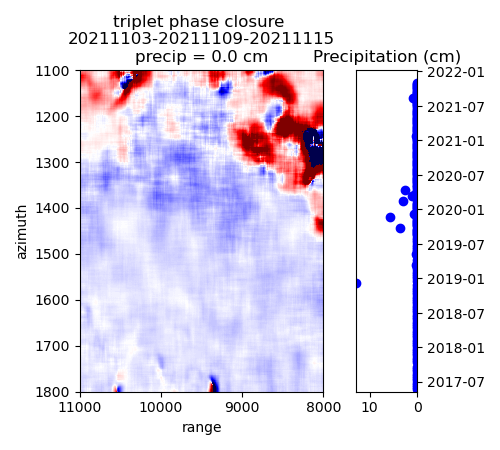

In [5]:
# plot single TPC map
i=200 # this tells it what igram date to plot precipitation up to
fig= plt.subplots(1,2,figsize=(5, 4.5),gridspec_kw={'width_ratios': [4, 1]},\
                  tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(tpc,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("triplet phase closure \n"+str(dates[i])+"-"+str(dates[i+1])+"-"+ \
          str(dates[i+2])+"\n"+ \
            "precip = "+str(round(precip[i],4))+' cm') 
plt.xlim([x2,x1])
plt.ylim([y2,y1])
# plot precipitation for that igram
ax = plt.subplot(1,2,2)
plt.plot(precip[1:i+1],slc_dates[1:i+1],'bo')
plt.ylim([slc_dates[0],slc_dates[-1]])
plt.xlim([np.max(precip),0])  
#plt.xlim([2, 0])
plt.title('Precipitation (cm)')
ax.yaxis.tick_right()
plt.show()

In [19]:
filenames = []
for i in np.arange(10,nd-2): # for all TPCs, use: np.arange(nd-2) I think
    # load in the 3 SLCs 
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", \
                gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+dates[i+2]+"/"+dates[i+2]+".slc.full", \
                gdal.GA_ReadOnly)
    slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
    # 3 SLCs, can make 2 sequential igrams
    int12 = slc1 * np.conj(slc2)
    int23 = slc2 * np.conj(slc3)
    int31 = slc3 * np.conj(slc1)
    # normalizing, didn't change anything 
    int12 = np.exp(1j*np.angle(int12))
    int23 = np.exp(1j*np.angle(int23))
    int31 = np.exp(1j*np.angle(int31))
    # now filter them by alooks/rlooks 
    alooks=40; rlooks=200
    int12filt = uniform_filter((int12), size=[alooks,rlooks])
    int23filt = uniform_filter((int23), size=[alooks,rlooks])
    int31filt = uniform_filter((int31), size=[alooks,rlooks])
    # calculate tpc
    tpc = np.angle(int12filt*int23filt*int31filt)
    
    #plot it
    fig= plt.subplots(1,2,figsize=(10, 9),gridspec_kw={'width_ratios': [4, 1]},\
                  tight_layout=True)
    plt.subplot(1,2,1)
    plt.imshow(tpc,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
    plt.ylabel('azimuth')
    plt.xlabel('range')
    plt.title("triplet phase closure \n"+str(dates[i])+"-"+str(dates[i+1])+"-"+ \
          str(dates[i+2])+"\n"+ \
            "precip = "+str(round(precip[i],4))+' cm') 
    plt.xlim([x2,x1])
    plt.ylim([y2,y1])
    
    # plot precipitation for that igram
    ax = plt.subplot(1,2,2)
    plt.plot(precip[1:i+1],slc_dates[1:i+1],'bo')
    plt.ylim([slc_dates[0],slc_dates[-1]])
    plt.xlim([np.max(precip),0])  
    #plt.xlim([2, 0])
    plt.title('Precipitation (cm) on center date')
    ax.yaxis.tick_right()
    
    # create file name and append it to a list
    filename = f'tpc{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close() 

IndexError: list index out of range

In [20]:
# If filenames doesn't have all the images in it, do this step:
filenames = []
for i in np.arange(nd-2): # for all TPCs, use: np.arange(nd-2) I think
    # create file name and append it to a list
    filename = f'tpc{i}.png'
    filenames.append(filename)

In [21]:
# build gif
with imageio.get_writer('TPCs.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

In [22]:
# modify the frame duration as needed
images = list(map(lambda filename: imageio.v2.imread(filename), filenames))
imageio.v2.mimsave(os.path.join('TPCs.gif'), images, duration = 0.5)

In [23]:
# Remove files
for filename in set(filenames):
    os.remove(filename)